In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

## Let's try it!

### Image preprocessing

In [521]:
#img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/data/1.jpg"
img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/new_chess_data/boards/board1.jpeg"
img = cv.imread(img_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

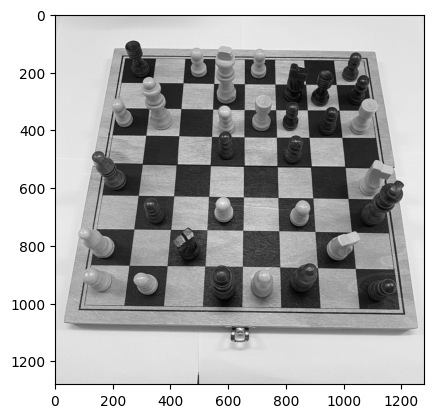

In [522]:
plt.imshow(img_gray,cmap="gray")

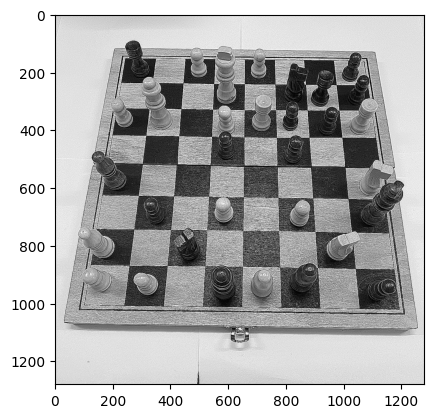

In [523]:
kernel = np.ones((5, 5), np.uint8)
kernel_sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharp = cv.filter2D(img_gray, -1, kernel_sharp)

img_erosion = cv.erode(blur, kernel, iterations=4)
img_dilation = cv.dilate(blur, kernel, iterations=3)

plt.imshow(img_sharp, cmap="gray")

### Processing and corners

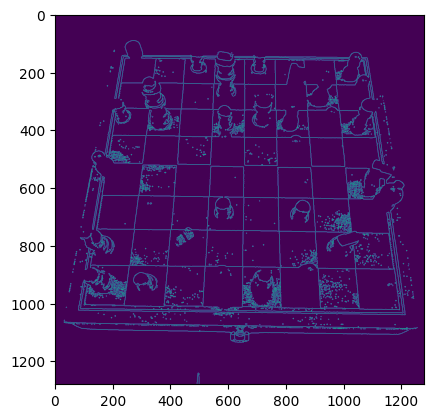

In [610]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
thres = cv.threshold(img_gray,140,255,cv.THRESH_BINARY)
blur = cv.blur(img_gray,(3,3),0)
edges = cv.Canny(thres[1], 150, 400) #70,250 for old
plt.imshow(edges)

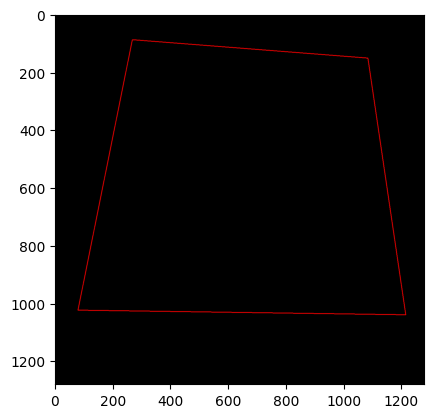

In [611]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_black = np.zeros((1280, 1280, 3), dtype = np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
dilated = cv.dilate(edges, kernel, iterations=2)
contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Approximate the contour shape to a polygon
    peri = cv.arcLength(contour, True)
    if peri > 2500:
        polygon = cv.approxPolyDP(contour, epsilon=0.05*cv.arcLength(contour, True), closed=False)
        sides = len(polygon)
        if sides == 3:
            pass
            #cv.drawContours(img_black, [polygon], 0, (0, 255, 0), 2)
        elif sides == 4:
            cv.drawContours(img_black, [polygon], 0, (0, 0, 255), 2)
        else:
            cv.drawContours(img_black, [polygon], 0, (255, 0, 0), 2)

plt.imshow(img_black)

4
[(1211, 1038), (81, 1022), (1080, 154), (269, 92)]


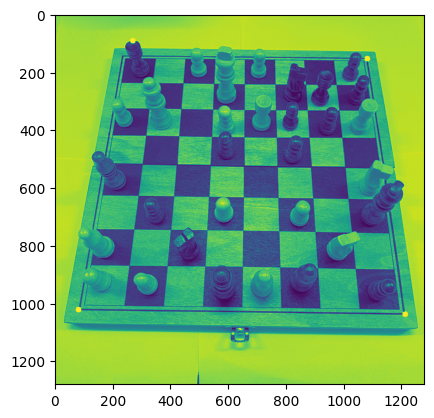

In [613]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_b = cv.cvtColor(img_black, cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(img_gray_b, 4, 0.4, 600)
corners = np.int0(corners)
point_corners = []
for corner in corners:
    x, y = corner.ravel()
    cv.circle(img_gray, (x,y), 10, 255, -1)
    point_corners.append((x,y))
print(len(point_corners))
print(point_corners)
plt.imshow(img_gray)

0
3
2
1


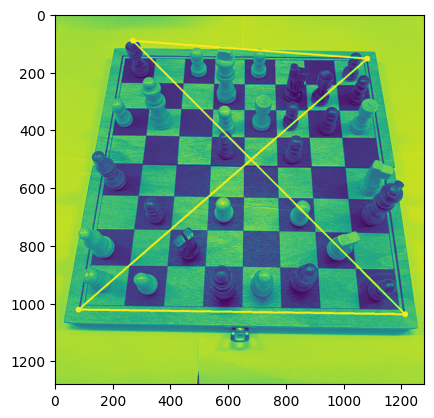

In [614]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    cv.line(img_gray, point_corners[c], point_corners[c-1], color = 255, thickness=5)
    i -=1
    
plt.imshow(img_gray)

In [568]:
def split_line(points1, points2, nb):
    x = np.linspace(points1[0],points2[0],nb)
    y = (points2[1]-points1[1])/(points2[0]-points1[0])*(x-points1[0]) + points1[1]
    return x, y

0
3
2
1


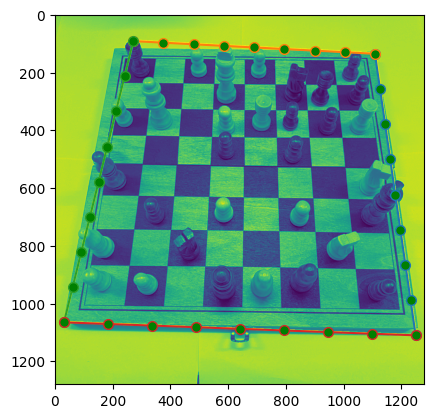

In [569]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
plt.imshow(img_gray)

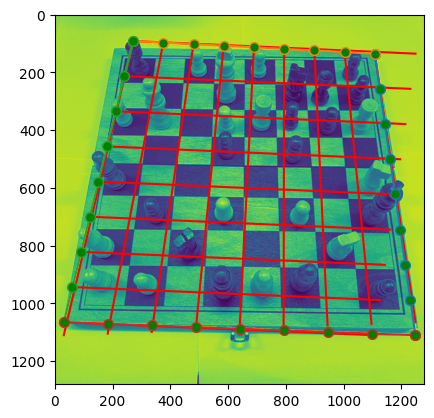

In [570]:
def line_btw_point(points1_1, points1_2, points2_1, points2_2):
    x_1, y_1 = split_line(points1_1, points1_2, 9)
    x_2, y_2 = split_line(points2_1, points2_2, 9)
    x_1 = np.sort(np.array(x_1))
    x_2 = np.sort(np.array(x_2))

    for i in range(len(x_1)):
        x = [x_1[i], x_2[i]]
        y = [y_1[i], y_2[i]]
        plt.plot(x,y, "r")
        ax = plt.gca()
        ax.set_xlim([0, 1280])
        ax.set_ylim([1280, 0])

line_btw_point(point_corners[0], point_corners[1], point_corners[2], point_corners[3])
line_btw_point(point_corners[0], point_corners[3], point_corners[1], point_corners[2])

i = 4
while i > 0:
    c = i % 4
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
    
plt.imshow(img_gray)

### Hough lines method

In [541]:
img_gray_2 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
lines = cv.HoughLines(edges, 1, np.pi/180, 250)

In [542]:
cart_equ = []
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cv.line(img_gray_2, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
            if b != 0:
                cart_equ.append(((-a/b), (rho/b)))
            else: cart_equ.append((0, rho))

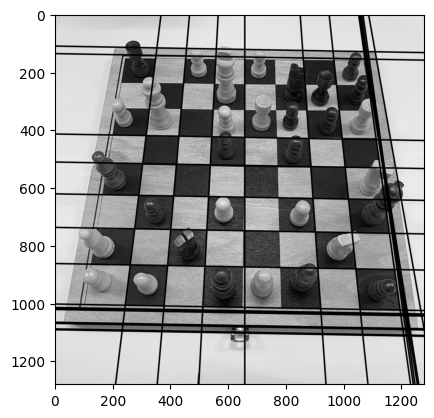

In [543]:
plt.imshow(img_gray_2,cmap="gray")

## Hough lines conversion

In [401]:
cart = pd.DataFrame(cart_equ).sort_values(by=1)
x_ca = cart[0]
y_ca = cart[1]

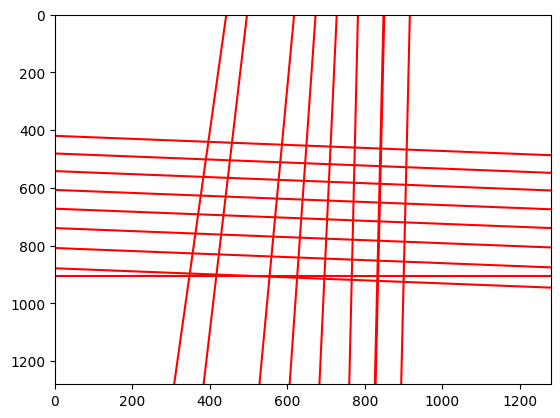

In [544]:
x = np.linspace(0,1280,len(x_ca))
for i in range(len(x_ca)):
    y = x_ca[i] * x + y_ca[i]
    plt.plot(x, y, '-r')
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])

In [16]:
def intersection(line1, line2):
    x0 = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y0 = line1[0] * x0 + line1[1]
    return x0, y0

In [17]:
intersections = []
for line1 in cart_equ:
    for line2 in cart_equ:
        if line1 != line2:
            if line1[0] - line2[0] != 0:
                x0, y0 = intersection(line1, line2)
                intersections.append((round(x0,0), round(y0,0)))

In [18]:
intersections_p = []
for x1,y1 in zip(x_ca, y_ca):
    for x2,y2 in zip(x_ca, y_ca):
        line1 = (x1, y1)
        line2 = (x2, y2)
        if line1 != line2:
            if line1[0] - line2[0] != 0:
                x0, y0 = intersection(line1, line2)
                intersections_p.append((round(x0,0), round(y0,0)))

In [19]:
intersections_pd = pd.DataFrame(intersections_p)
intersections_pd = intersections_pd[intersections_pd>0][intersections_pd<1281].dropna().drop_duplicates().reset_index()
x_in = intersections_pd[0].to_list()
y_in = intersections_pd[1].to_list()

### ploting from the list

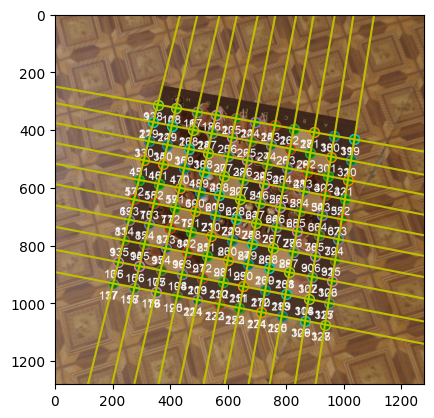

In [20]:
fig = plt.figure()
x = np.linspace(0,1280)
i = 0
img_2 = Image.open(img_path)

for inter in intersections_p:
    text = f"{i}"
    x1 = inter[0]
    y1 = inter[1]
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
    draw = ImageDraw.Draw(img_2)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text((x1-50,y1+20),text, font=font_type)
    i += 1

for coor in cart_equ:
    y2 = coor[0] * x + coor[1]
    plt.plot(x, y2, "y")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
plt.imshow(img_2)

### plotting from DataFrame

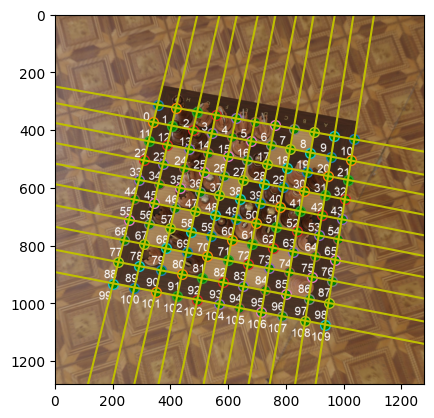

In [21]:
fig = plt.figure()
x = np.linspace(0,1280)
i = 0
img_2 = Image.open(img_path)

for i in range(len(x_in)):
    text = f"{i}"
    x1 = x_in[i]
    y1 = y_in[i]
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
    draw = ImageDraw.Draw(img_2)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text((x1-50,y1+20),text, font=font_type)

for coor in cart_equ:
    y2 = coor[0] * x + coor[1]
    plt.plot(x, y2, "y")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
plt.imshow(img_2)

## Coordinate generation

In [22]:
intersection_pd = intersections_pd.drop(columns="index")

In [23]:
A0 = intersection_pd.loc[9].to_list()

In [24]:
coordinate = {}
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
i = 1
for col in letters:
    for line in range(8):
        val = intersection_pd.loc[9-i + 11*line].to_list()
        text = f"{col}{line}"
        coordinate[text] = val
    i += 1
coordinate

{'A0': [898.0, 407.0],
 'A1': [885.0, 478.0],
 'A2': [874.0, 545.0],
 'A3': [862.0, 612.0],
 'A4': [850.0, 681.0],
 'A5': [838.0, 750.0],
 'A6': [825.0, 821.0],
 'A7': [812.0, 892.0],
 'B0': [827.0, 395.0],
 'B1': [815.0, 464.0],
 'B2': [803.0, 531.0],
 'B3': [791.0, 598.0],
 'B4': [779.0, 667.0],
 'B5': [767.0, 736.0],
 'B6': [754.0, 807.0],
 'B7': [742.0, 879.0],
 'C0': [762.0, 383.0],
 'C1': [749.0, 451.0],
 'C2': [736.0, 518.0],
 'C3': [723.0, 585.0],
 'C4': [709.0, 653.0],
 'C5': [696.0, 722.0],
 'C6': [682.0, 793.0],
 'C7': [668.0, 864.0],
 'D0': [692.0, 371.0],
 'D1': [679.0, 438.0],
 'D2': [666.0, 504.0],
 'D3': [653.0, 571.0],
 'D4': [640.0, 640.0],
 'D5': [626.0, 709.0],
 'D6': [613.0, 779.0],
 'D7': [599.0, 851.0],
 'E0': [627.0, 359.0],
 'E1': [613.0, 425.0],
 'E2': [599.0, 491.0],
 'E3': [585.0, 558.0],
 'E4': [570.0, 626.0],
 'E5': [556.0, 695.0],
 'E6': [541.0, 765.0],
 'E7': [526.0, 837.0],
 'F0': [557.0, 347.0],
 'F1': [543.0, 411.0],
 'F2': [529.0, 478.0],
 'F3': [515

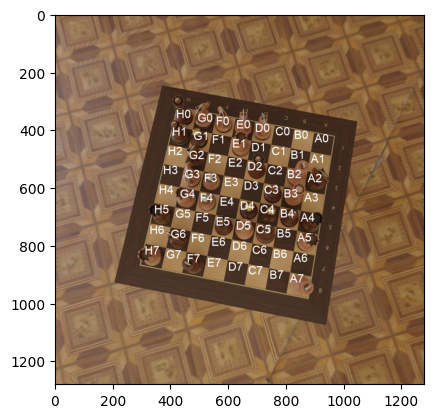

In [25]:
img_3 = Image.open(img_path)
for key, value in coordinate.items():
    text = key
    draw = ImageDraw.Draw(img_3)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(value,text, font=font_type)
plt.imshow(img_3)

## Colour detection

In [26]:
def pix_val(img, coor):
    return img.getpixel(coor)

In [27]:
def detect_colour(val):
    if val > 125:
        return "White"
    else: return "Black"

In [28]:
img_color = Image.open(img_path)
img_gray_pil = ImageOps.grayscale(img_color)

In [29]:
pick_A0 = (coordinate["A0"][0]+5, coordinate["A0"][1]+3)
pick_A7 = (coordinate["A7"][0]+5, coordinate["A7"][1]+3)
pick_H0 = (coordinate["H0"][0]+5, coordinate["H0"][1]+3)
pick_H7 = (coordinate["H7"][0]+5, coordinate["H7"][1]+3)

points = [pick_A0, pick_A7, pick_H0, pick_H7]

In [30]:
points[0]

(903.0, 410.0)

In [31]:
for point in points:
    text = detect_colour(pix_val(img_gray_pil, point))
    draw = ImageDraw.Draw(img_gray_pil)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(point,text, font=font_type, fill=255)

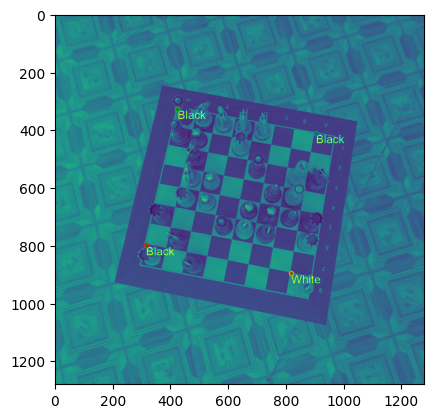

In [32]:
plt.plot(pick_A0[0],pick_A0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_A7[0],pick_A7[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H0[0],pick_H0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H7[0],pick_H7[1], marker="o", markersize=3, markerfacecolor="green")
plt.imshow(img_gray_pil)